<a href="https://colab.research.google.com/github/mayanksh-111/Tweet_Tracker_230642/blob/main/Tweet_Tracker_230642.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `Tweet Sentiment Analysis`

`This project uses the Sentiment140 dataset to classify tweets as positive, negative, or neutral. We clean, tokenize, and process the text to prepare it for sentiment analysis.`

In [ ]:
%pip install snscrape pandas vaderSentiment textblob
!pip install ntlk
import snscrape.modules.twitter as sntwitter
import pandas as pd

# `Downloading the tweet data using Kaggle API`
`This block checks if the Sentiment140 dataset file (training.1600000.processed.noemoticon.csv) already exists. If not, it:`  

`1. Prompts the user to upload the kaggle.json API key,`  
`2. Sets up Kaggle credentials`  
`3. Downloads the dataset from Kaggle using the API`  
`4. Unzips the dataset for use`  
`5. If the file is already present, it skips the download to save time`

In [ ]:
import os
file_path = 'training.1600000.processed.noemoticon.csv'

if not os.path.exists(file_path):
    from google.colab import files
    uploaded = files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d kazanova/sentiment140
    !unzip sentiment140.zip
else:
    print("Dataset already exists. Skipping download.")


Dataset already exists. Skipping download.


In [ ]:
tweets = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding='latin-1',header=None)
tweets.columns = ["target", "id", "date", "flag", "user", "text"]
tweets.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## `Cleaning Raw Tweets`  

`This function converts tweets to lowercase and removes URLs, mentions, hashtags, punctuation, and extra spaces to simplify the text.`


In [ ]:
import re
def clean_tweet(text):
    t = str(text).lower()
    t = re.sub(r"http\S+|www\S+|https\S+", "", t)
    t = re.sub(r"\@\w+", "", t)
    t = re.sub(r"#", "", t)
    t = re.sub(r"[^\w\s]", "", t)
    return t.strip()

tweets["text1"] = tweets["text"].apply(clean_tweet)
tweets[["text", "text1"]].head()

,text,text1
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",a thats a bummer you shoulda got david carr o...
1,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...


## `Data Preparation and NLTK Setup and Stopword Removal`  

* `Removes missing or very short tweets, and ensures NLTK resources ('punkt' and 'stopwords') are downloaded and accessible.`

* `Removes common English stopwords using regex-based tokenization to reduce noise and keep meaningful words.`

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re

tweets.dropna(subset=['text'], inplace=True)
tweets = tweets[tweets['text'].str.split().str.len() >= 3]

nltk.download('punkt', download_dir='/usr/local/nltk_data')
nltk.download('stopwords', download_dir='/usr/local/nltk_data')
nltk.data.path.append('/usr/local/nltk_data')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

tweets['clean_text'] = tweets['text1'].apply(remove_stopwords)
tweets.reset_index(drop=True, inplace=True)

tweets.to_csv("week2_cleaned.csv", index=False)

[nltk_data] Downloading package punkt to /usr/local/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/local/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tweets[['text1','clean_text']].head()

,text1,clean_text
0,a thats a bummer you shoulda got david carr o...,thats bummer shoulda got david carr third day
1,is upset that he cant update his facebook by t...,upset cant update facebook texting might cry r...
2,i dived many times for the ball managed to sav...,dived many times ball managed save 50 rest go ...
3,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,no its not behaving at all im mad why am i her...,behaving im mad cant see


## `Sentiment Analysis using VADER`  

`This block uses the VADER sentiment analyzer to assign a sentiment score ("compound") to each tweet. Based on the score, we classify tweets as Positive, Negative, or Neutral.`


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def get_lable(score):
  if score >= 0.05:
    return "Positive"
  elif score <= -0.05:
    return "Negative"
  else :
    return "Neutral"

tweets["sentiment_score_vader"] = tweets["clean_text"].apply(lambda x: analyzer.polarity_scores(str(x))["compound"])
tweets["sentiment_label_vader"] = tweets["sentiment_score_vader"].apply(get_lable)

## `Sentiment Analysis using TextBlob`  

`This block applies TextBlob to calculate the polarity and subjectivity of each tweet. Tweets are then labeled as Positive, Negative, or Neutral based on their polarity score.`


In [ ]:
from textblob import TextBlob

def analyze_sentiment(text):
    blob = TextBlob(str(text))
    return pd.Series({
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity
    })

tweets[['sentiment_score_textblob', 'subjectivity_textblob']] = tweets['clean_text'].apply(analyze_sentiment)

def get_lable(polarity):
    if polarity >= 0.05:
        return "Positive"
    elif polarity <= -0.05:
        return "Negative"
    else:
        return "Neutral"

tweets['sentiment_label_textblob'] = tweets['sentiment_score_textblob'].apply(get_lable)


# `Checking Sentiment Agreement:`   
`In this part, we check how often VADER and TextBlob agree on the sentiment of a tweet. For each tweet, we compare the labels from both tools and calculate the percentage of matches. This gives us an idea of how consistent the two tools are with each other.`

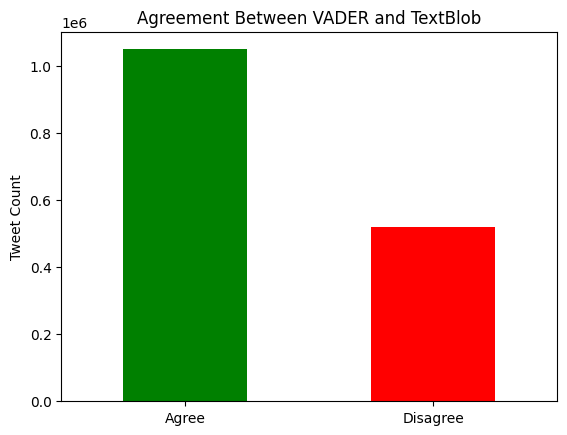

Agreement Percentage: 66.85%

Tweet:
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
TextBlob Sentiment: Neutral
VADER Sentiment   : Negative
------------------------------------------------------------
Tweet:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
TextBlob Sentiment: Neutral
VADER Sentiment   : Negative
------------------------------------------------------------
Tweet:
my whole body feels itchy and like its on fire 
TextBlob Sentiment: Positive
VADER Sentiment   : Negative
------------------------------------------------------------
Tweet:
@Kwesidei not the whole crew 
TextBlob Sentiment: Positive
VADER Sentiment   : Neutral
------------------------------------------------------------
Tweet:
Need a hug 
TextBlob Sentiment: Neutral
VADER Sentiment   : Positive
------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt

agree_cnt = sum(tweets['sentiment_label_vader'] == tweets['sentiment_label_textblob'])
disagree_cnt = len(tweets) - agree_cnt
counts = pd.Series([agree_cnt, disagree_cnt], index=['Agree', 'Disagree'])
counts.plot(kind='bar', color=['green', 'red'])
plt.xticks([0, 1], ['Agree', 'Disagree'], rotation=0)
plt.title('Agreement Between VADER and TextBlob')
plt.ylabel('Tweet Count')

plt.show()
match_count = (tweets['sentiment_label_textblob'] == tweets['sentiment_label_vader']).sum()
print(f"Agreement Percentage: {((match_count/len(tweets))* 100):.2f}%\n")


mismatch_df = tweets[tweets['sentiment_label_textblob'] != tweets['sentiment_label_vader']]
mismatched_samples = mismatch_df[['text', 'sentiment_label_textblob', 'sentiment_label_vader']].head(5)
for idx, row in mismatched_samples.iterrows():
    print("Tweet:")
    print(row['text'])
    print("TextBlob Sentiment:", row['sentiment_label_textblob'])
    print("VADER Sentiment   :", row['sentiment_label_vader'])
    print("-" * 60)

# `Comparing Sentiment Distributions:`  
`Here, we count how many tweets are labeled as Positive, Neutral, or Negative by both VADER and TextBlob. We then plot these counts side by side in a bar chart to visually compare how each tool interprets the overall mood of the tweets.`

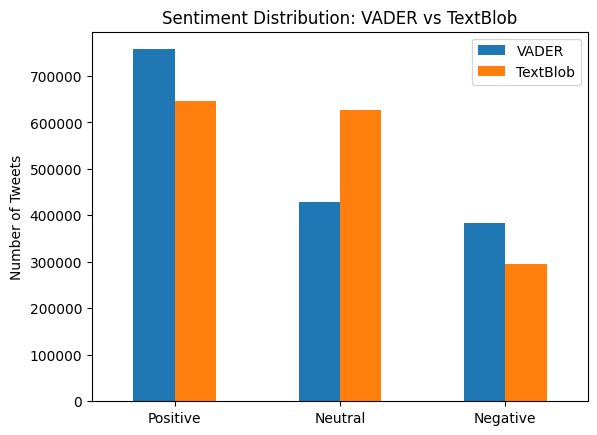

In [ ]:
import matplotlib.pyplot as plt

vader_counts = tweets['sentiment_label_vader'].value_counts()
textblob_counts = tweets['sentiment_label_textblob'].value_counts()

df_compare = pd.DataFrame({'VADER': vader_counts, 'TextBlob': textblob_counts})
df_compare.plot(kind='bar', rot=0)
plt.title('Sentiment Distribution: VADER vs TextBlob')
plt.ylabel('Number of Tweets')
plt.show()

# `Sentiment Score Distributions:`  
`Finally, we look at how the actual sentiment scores (not just labels) from both tools are spread out. We use histograms to show whether the tweets mostly lean positive, negative, or stay neutral, according to each tool.`

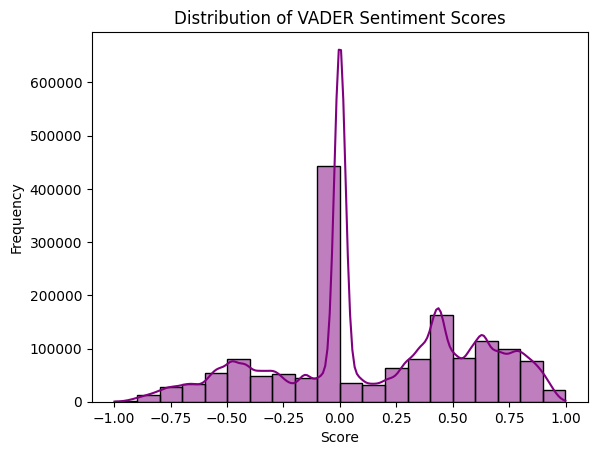

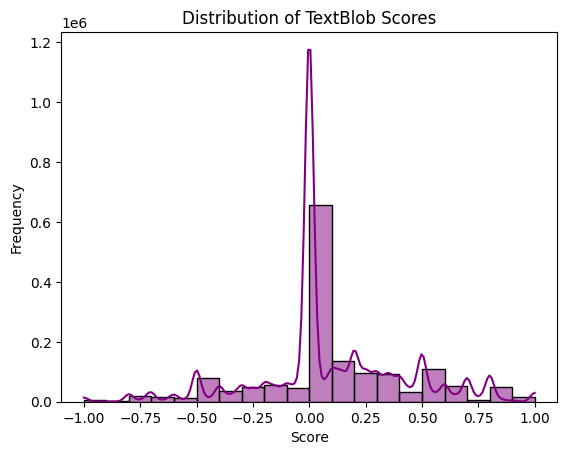

In [ ]:

import seaborn as sns

sns.histplot(tweets['sentiment_score_vader'], bins=20, kde=True, color='purple')
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

sns.histplot(tweets['sentiment_score_textblob'], bins=20, kde=True, color='purple')
plt.title('Distribution of TextBlob Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


#` Count of each sentiment for both models`
`This section creates a summary table that compares the number of Positive, Neutral, and Negative tweets identified by each sentiment analysis model — TextBlob and VADER. It counts how many tweets fall into each category for both models and adds a total column showing the overall number of tweets analyzed by each. The summary helps quickly compare the output of both tools side by side.`

In [ ]:
summary = pd.DataFrame({
    "Model": ["TextBlob", "VADER"],
    "Positive": [tweets["sentiment_label_textblob"].value_counts().get("Positive", 0),
                 tweets["sentiment_label_vader"].value_counts().get("Positive", 0)],
    "Neutral": [tweets["sentiment_label_textblob"].value_counts().get("Neutral", 0),
                tweets["sentiment_label_vader"].value_counts().get("Neutral", 0)],
    "Negative": [tweets["sentiment_label_textblob"].value_counts().get("Negative", 0),
                 tweets["sentiment_label_vader"].value_counts().get("Negative", 0)],
})
summary["Total"] = summary[["Positive", "Neutral", "Negative"]].sum(axis=1)

print(summary)
pos_percent_vader = (summary.loc[1, 'Positive']/summary.loc[1,'Total'])*100   # if index is integer 1
neg_percent_vader = (summary.loc[1,'Negative']/summary.loc[1,'Total'])*100
neutral_percent_vader = 100 - pos_percent_vader - neg_percent_vader

pos_percent_textblob = (summary.loc[0, 'Positive']/summary.loc[0,'Total'])*100
neg_percent_textblob = (summary.loc[0, 'Negative']/summary.loc[1,'Total'])*100
neutral_percent_textblob = 100 - pos_percent_textblob - neg_percent_textblob
print("\n")
print(f"Vader Positive Percentage: {pos_percent_vader:.2f}%")
print(f"Vader Negative Percentage: {neg_percent_vader:.2f}%")
print(f"Vader Neutral Percentage: {neutral_percent_vader:.2f}%\n")
print(f"TextBlob Positive Percentage: {pos_percent_textblob:.2f}%")
print(f"TextBlob Negative Percentage: {neg_percent_textblob:.2f}%")
print(f"Vader Neutral Percentage: {neutral_percent_textblob:.2f}%")

      Model  Positive  Neutral  Negative    Total
0  TextBlob    646461   627119    295329  1568909
1     VADER    757225   429102    382582  1568909


Vader Positive Percentage: 48.26%
Vader Negative Percentage: 24.39%
Vader Neutral Percentage: 27.35%

TextBlob Positive Percentage: 41.20%
TextBlob Negative Percentage: 18.82%
Vader Neutral Percentage: 39.97%


# `Creating Wordcloud`
**1: ForVader**  
> ```This part generates two word clouds — one for positive tweets and one for negative tweets (based on VADER labels). It combines all the cleaned text from each category into one string and uses the WordCloud library to visualize the most frequently used words. The result is displayed side by side, helping us easily spot which words appear most often in positive versus negative tweets.```


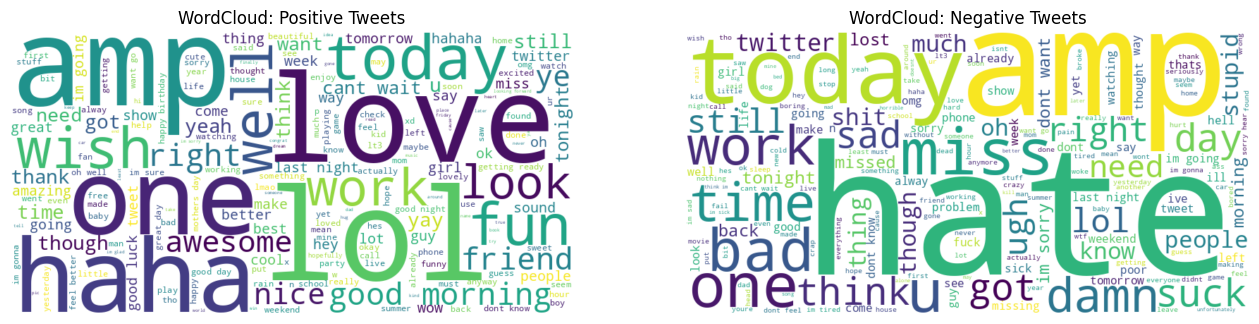

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_text = " ".join(tweets[tweets["sentiment_label_vader"] == "Positive"]["clean_text"])
negative_text = " ".join(tweets[tweets["sentiment_label_vader"] == "Negative"]["clean_text"])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("WordCloud: Positive Tweets")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("WordCloud: Negative Tweets")
plt.axis("off")
plt.show()


**2: For TextBlob**
>`This section creates word clouds based on the sentiment labels given by TextBlob. It gathers all cleaned positive and negative tweets separately, combines them into two large text strings, and then visualizes the most common words in each group using the WordCloud library. The side-by-side display highlights the key terms associated with positive and negative sentiments according to TextBlob.`

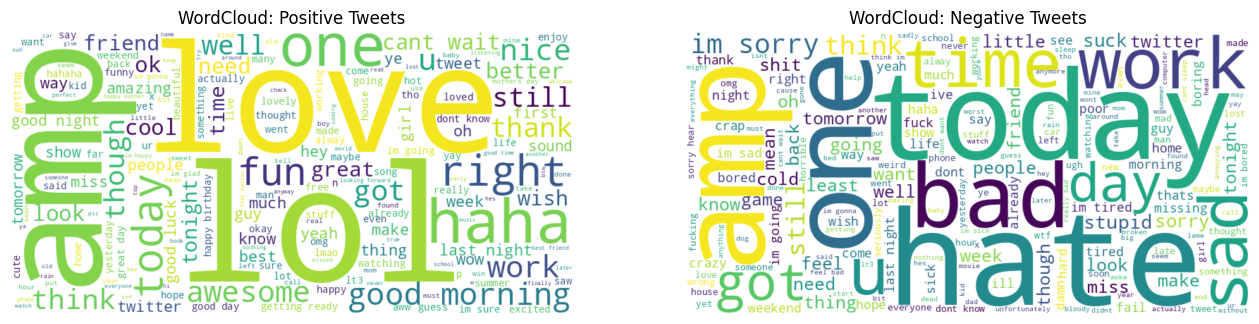

In [ ]:
positive_text2 = " ".join(tweets[tweets["sentiment_label_textblob"] == "Positive"]["clean_text"])
negative_text2 = " ".join(tweets[tweets["sentiment_label_textblob"] == "Negative"]["clean_text"])

wordcloud_pos2 = WordCloud(width=800, height=400, background_color='white').generate(positive_text2)
wordcloud_neg2 = WordCloud(width=800, height=400, background_color='white').generate(negative_text2)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos2, interpolation='bilinear')
plt.title("WordCloud: Positive Tweets")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg2, interpolation='bilinear')
plt.title("WordCloud: Negative Tweets")
plt.axis("off")
plt.show()

# **`Key Insights:`**
* `According to VADER` **`48.26%`** `tweets were Positive and` **`24.39%`** `were Negative`
* `According to TextBlob` **`41.20%`** `tweets were Positive and` **`18.82%`** `were Negative`
* `Some common words in Positive Sentiment were` **`"love"`**, **`"lol"`**, **`"haha"`** etc.`
* `Some common words in Negative Sentiment were` **`"hate"`**, **`"bad"`**, **`"today"`** `etc.`
* `Agree Percentage of both Models is` **`66.85%`** `by that we can say that both models` **`often agree`** `on the sentiment of a tweet.`
* **`Some examples of misclassification:`**  
  **1. `Tweet`: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D`**  
    * `TextBlob Sentiment: Neutral`
    * `VADER Sentiment   : Negative`
  ------------------------------------------------------------
  **2. `Tweet: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!`**
  * `TextBlob Sentiment: Neutral`
  * `VADER Sentiment   : Negative`
  ------------------------------------------------------------
  **3. `Tweet:my whole body feels itchy and like its on fire`**
  * `TextBlob Sentiment: Positive`
  * `VADER Sentiment   : Negative`
  ------------------------------------------------------------
  **4. `Tweet: @Kwesidei not the whole crew`**
  * `TextBlob Sentiment: Positive`
  * `VADER Sentiment   : Neutral`
  ------------------------------------------------------------
  **5. `Tweet: Need a hug`**
  * `TextBlob Sentiment: Neutral`
  * `VADER Sentiment   : Positive`
  ------------------------------------------------------------


# `Final File Save`
`This block saves a csv file named "final_sentiment_dataset.csv" which includes original tweet, cleaned tweet, sentiment scores and labels for both models`

In [ ]:
col_to_take = [col for col in ['text','clean_text','sentiment_label_textblob','sentiment_score_textblob','sentiment_label_vader','sentiment_score_vader']]
final_sentiment_dataset = tweets[col_to_take]
tweets.to_csv("final_sentiment_dataset.csv", index=False)
final_sentiment_dataset.head()

,text,clean_text,sentiment_label_textblob,sentiment_score_textblob,sentiment_label_vader,sentiment_score_vader
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",thats bummer shoulda got david carr third day,Neutral,0.000,Negative,-0.3818
1,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...,Neutral,0.000,Negative,-0.7269
2,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save 50 rest go ...,Positive,0.500,Positive,0.4939
3,my whole body feels itchy and like its on fire,whole body feels itchy like fire,Positive,0.200,Negative,-0.2500
4,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see,Negative,-0.625,Negative,-0.4939
